# Import Modules

In [1]:
# including the project directory to the notebook level
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#importing modules
import warnings
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,7)

#modules for data reading and parsing dates
from dataprocess import dataprocessor as dp

# Get the raw VRF data from csv files

### Load the data into data frame

In [3]:
# load data path
vrfdata = dp.readfolder('../data/raw/VRF_setpoint/',
                        timeformat='%Y-%m-%d %H:%M:%S',
                        dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['files2dflist', 'datetime_parse_dflist', 'merge_dflist']
vrf = vrfdata.return_df(processmethods=processmethods)

### Remove the constant value cols and Nan rows

In [5]:
# Drop Columns where >5% of values are missing
vrf = dp.dropNaNcols(vrf, threshold=0.95)

# Drop columns of constant values if needed
vrf = dp.constantvaluecols(vrf, limit=0.2)

### Plot the data

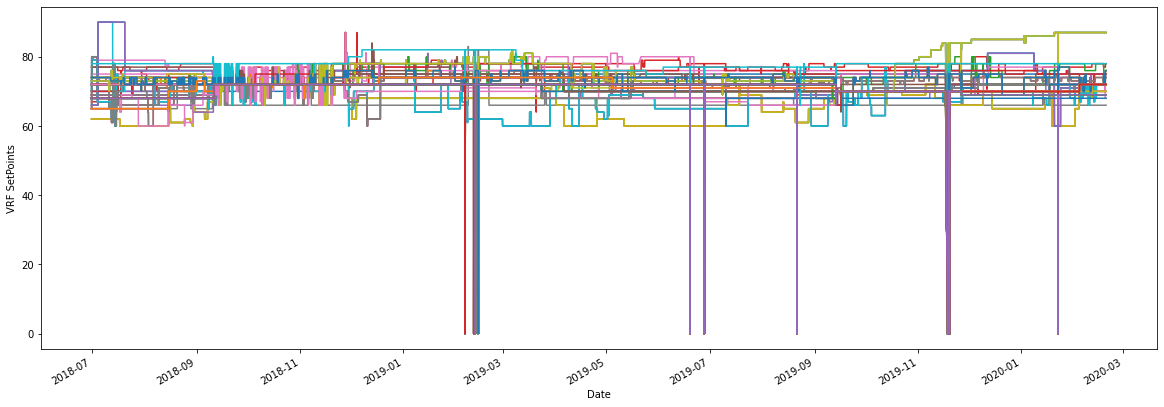

Finished 'dataframeplot' in 4.8604 secs


In [6]:
# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

### Remove collective outliers based on bounds


Retaining 97.79391149946264% of the data
Finished 'removeoutliers' in 6.5261 secs


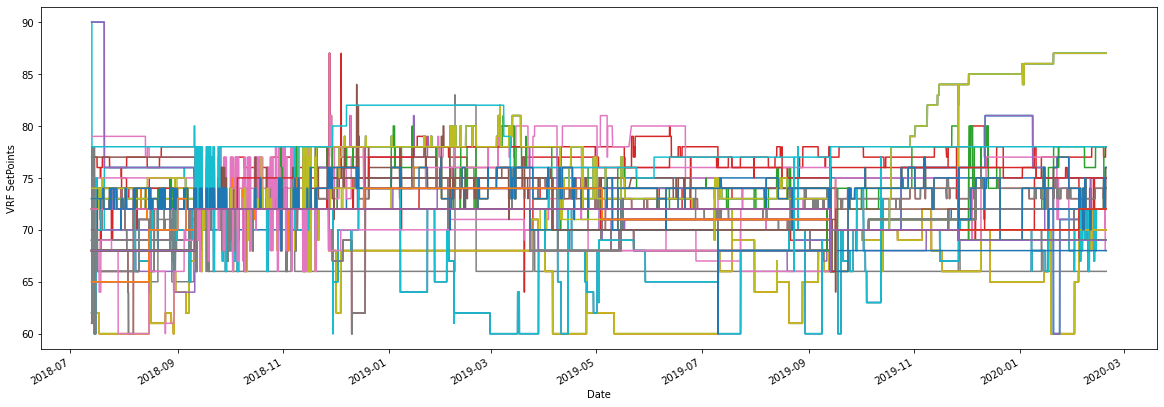

Finished 'dataframeplot' in 4.5810 secs


In [7]:
# remove outliers based on bounds
vrf = dp.removeoutliers(vrf,
                        columns=vrf.columns,
                        upperbound=100,
                        lowerbound=40)

# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

### Resample data at 5 min intervals with asfreq return. This will give back the NaNs

In [27]:
vrf_resampled = vrf.copy()

In [28]:
vrf_resampled = vrf_resampled.resample('5min').asfreq()

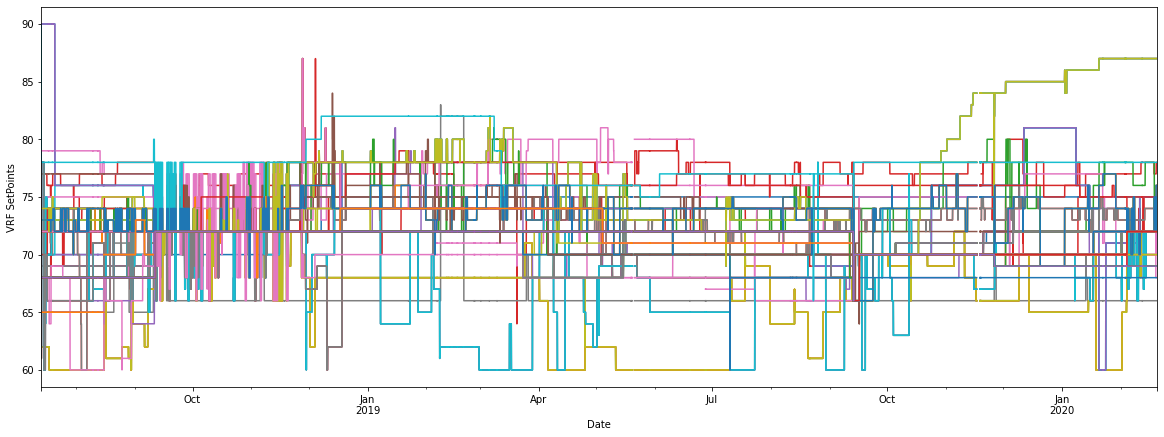

Finished 'dataframeplot' in 26.9284 secs


In [29]:
# Plot the df
dp.dataframeplot(vrf_resampled, ylabel='VRF SetPoints', xlabel='Date', style='-')

### Interpolate

In [32]:
vrf_interpolated = vrf_resampled.interpolate(method='cubic')

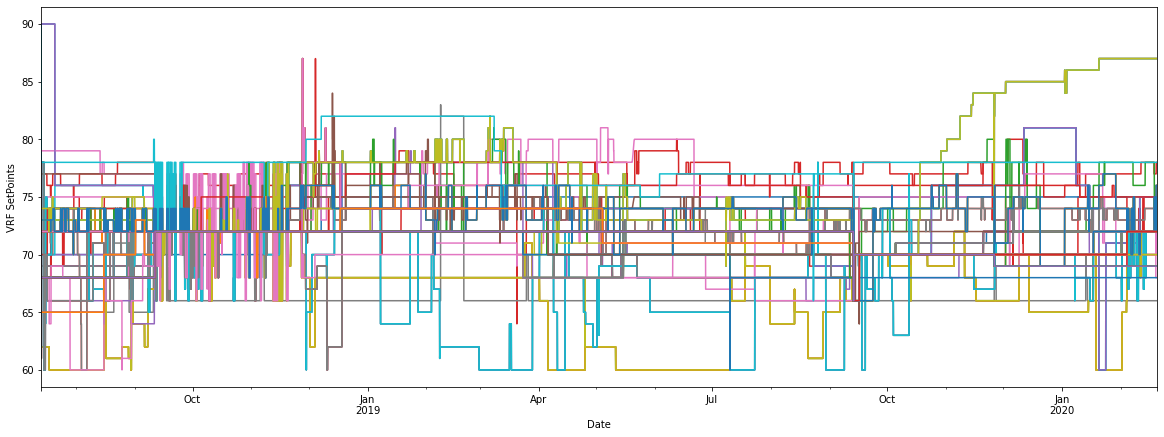

Finished 'dataframeplot' in 27.1260 secs


In [34]:
# Plot the df
dp.dataframeplot(vrf_interpolated, ylabel='VRF SetPoints', xlabel='Date', style='-')

### Save the dataframe

In [99]:
# saving the data
vrf_interpolated.to_pickle('../data/processed/interpolated/vrf_interpolated.pkl')

# Get the raw Alumni AHU data from CSV files

### Load the data into data frame

In [36]:
# load data path
ahudata = dp.readfile('../data/raw/energyvars/FileAHU.csv',
                      timeformat='%Y-%m-%d %H:%M:%S+00:00',
                      dateheading='time')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
ahu = ahudata.return_df(processmethods=processmethods)

### Remove certain cols, remove cols with high percentage of NaNs, remove NaN rows

In [37]:
# drop cooling tower humidity infos as they contain constant values which seem unreliable
ahu = ahu.drop(
    columns=['Chiller_1 outdoorAirHumidity', 'CT_2 outdoorAirHumidity'])

# Drop Columns where >5% of values are NaN
ahu = dp.dropNaNcols(ahu, threshold=0.95)

# Drop rows with NaN
ahu = dp.dropNaNrows(ahu)

### Plot the data

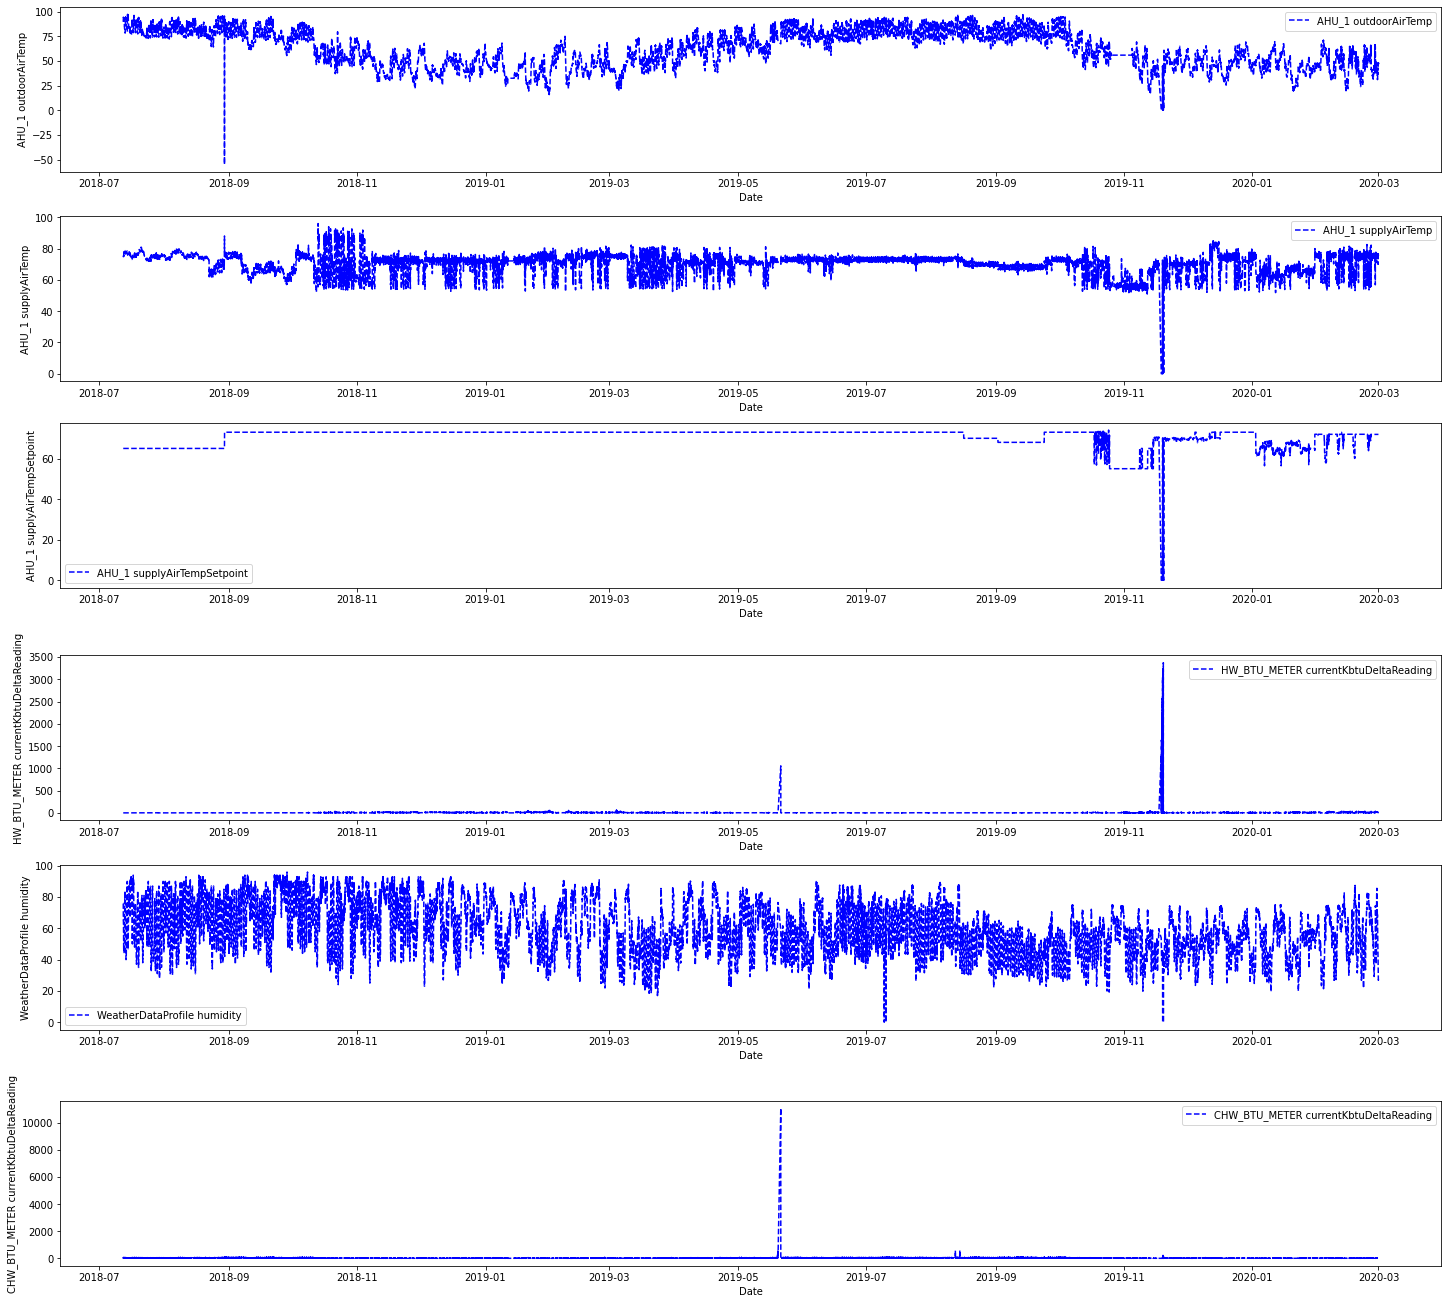

Finished 'dataframeplot' in 4.8779 secs


In [38]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True)

### Some data incorporate both statistical outliers and collective point outliers. We have to first remove the collective point outliers to perform meaningful statistical outlier based removal

In [ ]:
# remove outleirs based on bounds
# 1 remove on hw energy bounds
# 2 remove on chw energy bounds
# 3 remove on setpoint bounds
# 4 remove on supply air temperature
# 5  remove on outside air temeprature
name = ['AHU_1 supplyAirTempSetpoint', 'HW_BTU_METER currentKbtuDeltaReading',\
        'CHW_BTU_METER currentKbtuDeltaReading', 'AHU_1 supplyAirTemp', 'AHU_1 outdoorAirTemp']
u_bound = [90, 500, 100, 90, 120]
l_bound = [40, -1, -1, 40, -10]
for i in range(len(name)):
    ahu = dp.removeoutliers(ahu,
                            columns=[name[i]],
                            upperbound=u_bound[i],
                            lowerbound=l_bound[i])

In [39]:
# remove outliers based on z-thresh
col_list = [
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'WeatherDataProfile humidity', 'CHW_BTU_METER currentKbtuDeltaReading', 'HW_BTU_METER currentKbtuDeltaReading'
]
ahu = dp.removeoutliers(ahu, columns=list(ahu.columns), z_thresh=3)

Retaining 96.41924414723553% of the data
Finished 'removeoutliers' in 0.0789 secs


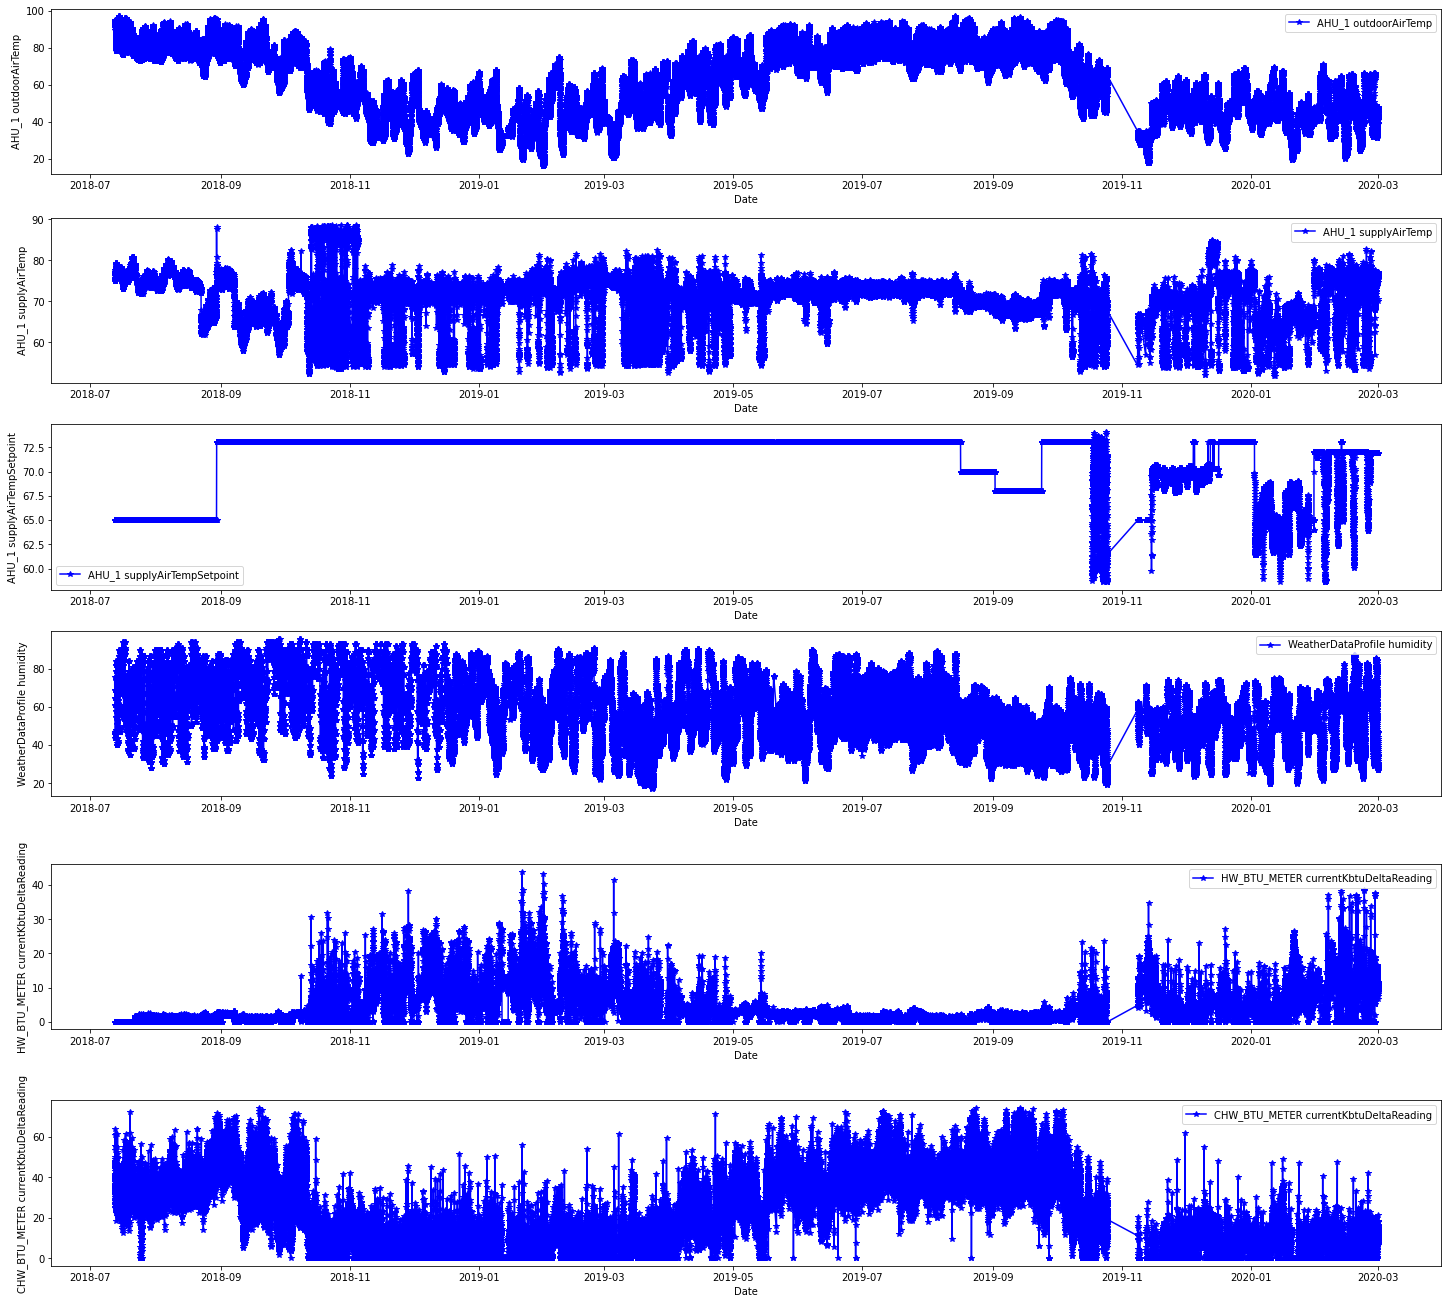

Finished 'dataframeplot' in 4.1348 secs


In [74]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True, style='b*-')

### Rearange cols for later use

In [41]:
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'AHU_1 supplyAirTempSetpoint', 'WeatherDataProfile humidity',
    'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

### Resample data at 5 min intervals with asfreq. This will give back the NaN locations

In [42]:
ahu_resampled = ahu.copy()

In [43]:
ahu_resampled = ahu_resampled.resample('5min').asfreq()

### Interpolate

In [112]:
ahu_interpolated = ahu_resampled.interpolate(method='linear')

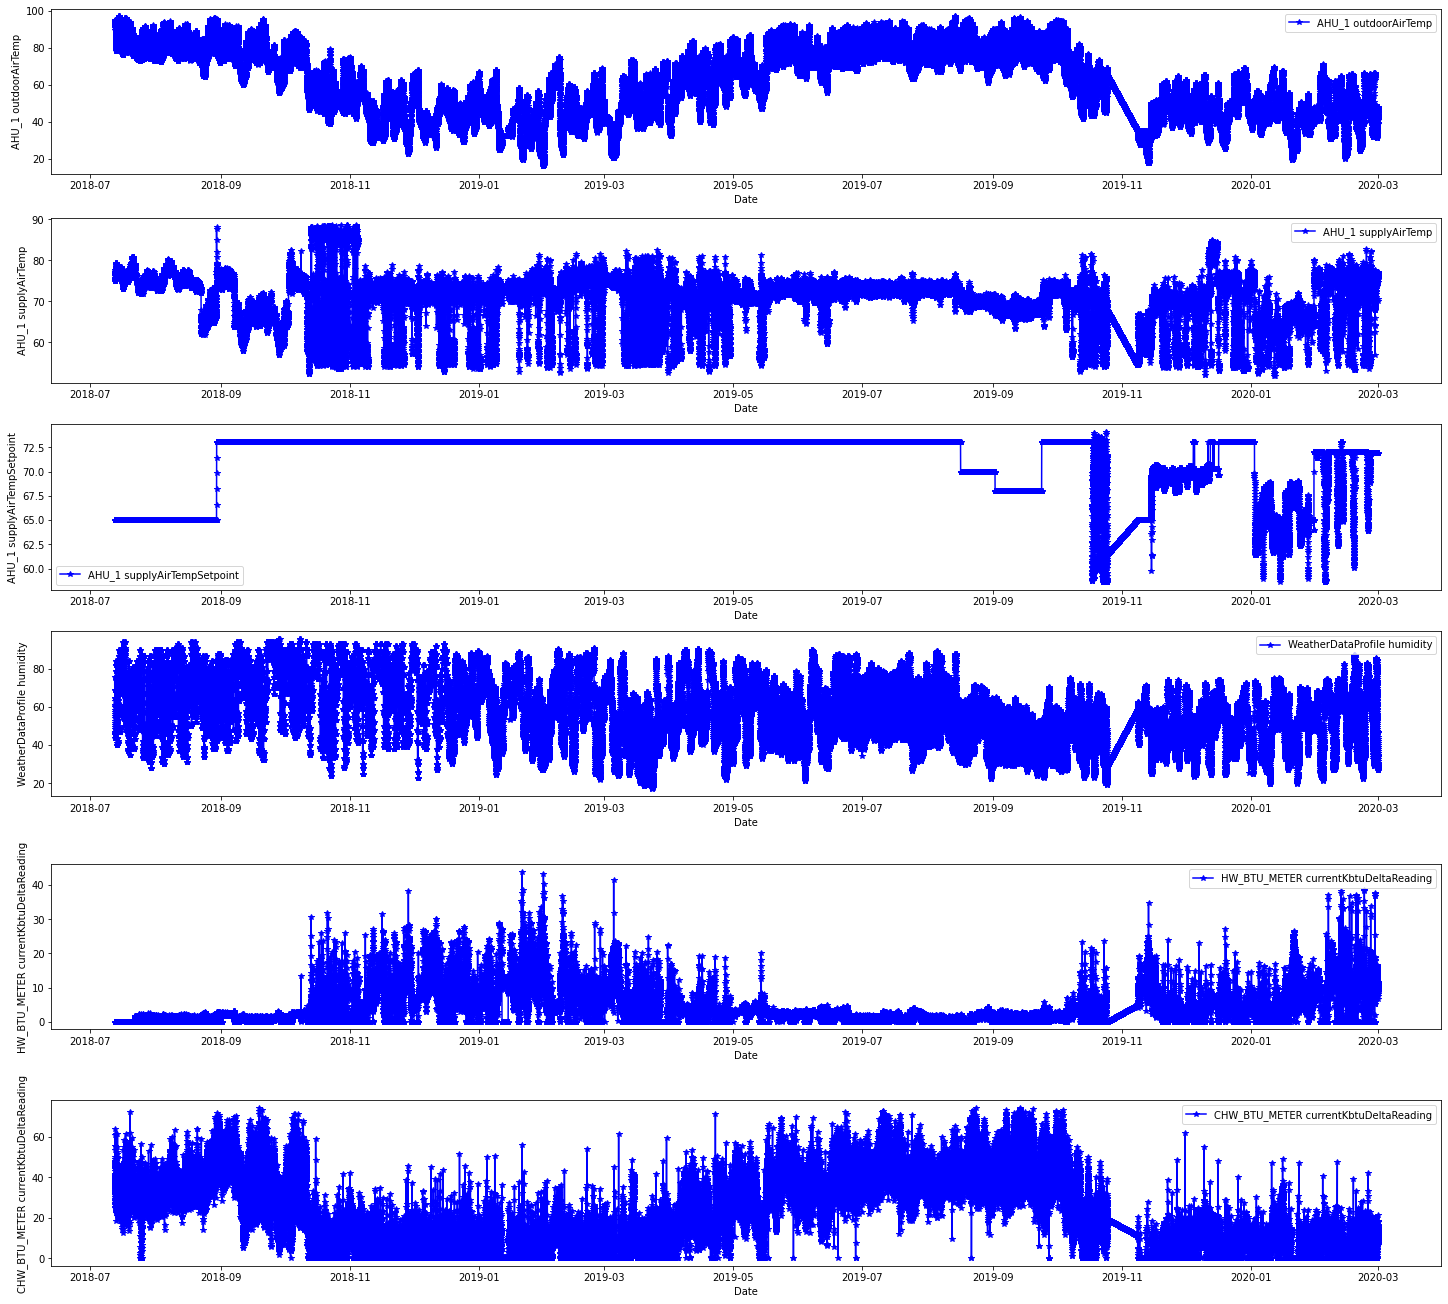

Finished 'dataframeplot' in 4.4873 secs


In [113]:
# Plot the df
dp.dataframeplot(ahu_interpolated, xlabel='Date', lazy=False, legend=True, style='b*-')

### Save the dataframe

In [135]:
# save the data in pickeld format
ahu_interpolated.to_pickle('../data/processed/interpolated/ahu_interpolated.pkl')

# Get raw solar GHI information

### Load the data into a dataframe

In [86]:
# get old solar irradiation data from july 12th 2018 to Oct 23rd 2019

# load data path
olddata = dp.readfile('../data/raw/solardata/RL_relearn_data_v2.pkl')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df']
olddf = olddata.return_df(processmethods=processmethods)

# We need only ghi data
olddf = olddf[['Ghi']]

In [87]:
# get new Solar irradiation data from Oct 23rd 2019 to present data

# load data path
newdata = dp.readfile('../data/raw/solardata/Nashville_Solcast_PT5M.csv',
                     dateheading="PeriodEnd", timeformat='%Y-%m-%dT%H:%M:%SZ')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
newdf = newdata.return_df(processmethods=processmethods)

# Since it still contains many redundant cols we retain only Ghi
newdf = newdf[['Ghi']]

In [88]:
# merge old and new solar irradiation data
ghidf = dp.mergerows([olddf, newdf])

In [89]:
ghidf.head()

,Ghi
2018-07-12 08:55:00,745.0
2018-07-12 09:00:00,758.0
2018-07-12 09:05:00,772.0
2018-07-12 09:10:00,785.0
2018-07-12 09:15:00,798.0


### Remove the statistical outliers in the data

In [91]:
# removing statistical outliers if any
# remove outliers based on z-thresh
col_list = ['Ghi']
ghidf = dp.removeoutliers(ghidf, columns=col_list, z_thresh=3)

Retaining 99.23988053555503% of the data
Finished 'removeoutliers' in 0.0248 secs


### Plot the new data

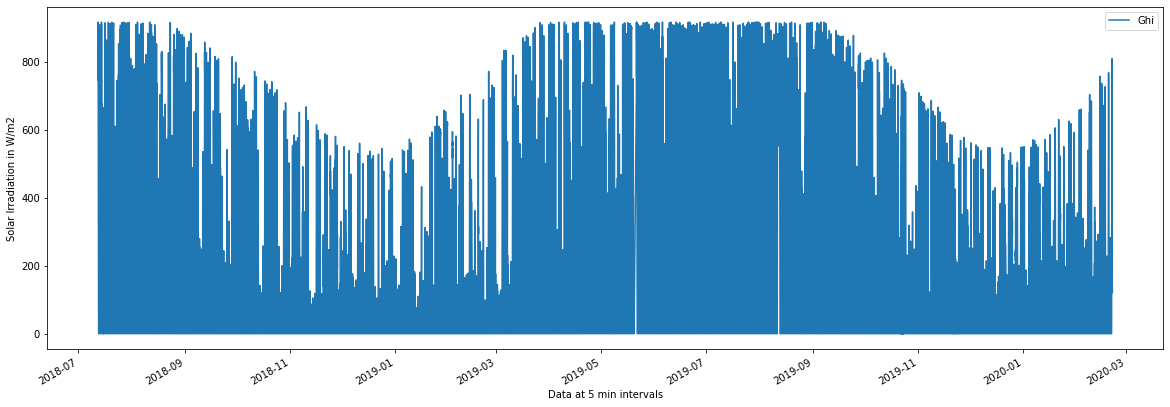

Finished 'dataframeplot' in 2.2260 secs


In [92]:
dp.dataframeplot(df=ghidf,
                 style='-',
                 xlabel='Data at 5 min intervals',
                ylabel='Solar Irradiation in W/m2',
                legend=True)

### Resample data at 5 min intervals with asfreq. This will give back the NaN locations

In [93]:
ghidf_resampled = ghidf.copy()

In [94]:
ghidf_resampled = ghidf_resampled.resample('5min').asfreq()

### Interpolate

In [97]:
ghidf_interpolated = ghidf_resampled.interpolate(method='linear')

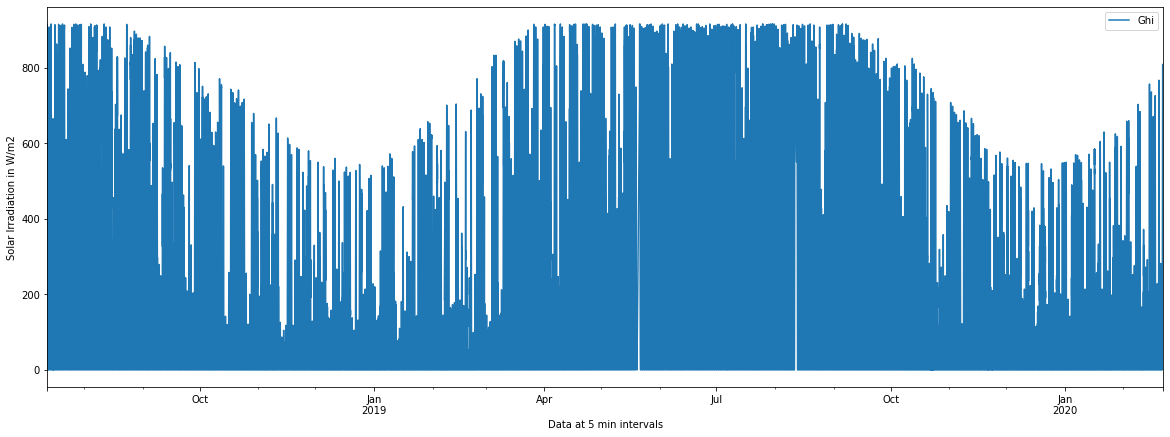

Finished 'dataframeplot' in 3.1398 secs


In [98]:
dp.dataframeplot(df=ghidf_interpolated,
                 style='-',
                 xlabel='Data at 5 min intervals',
                ylabel='Solar Irradiation in W/m2',
                legend=True)

### Save the data

In [100]:
# Saving the processed data
ghidf_interpolated.to_pickle('../data/processed/interpolated/ghidf_interpolated.pkl')

# Get raw Primary Chilled Water Flow information

### Load the data into a dataframe

In [101]:
# load data path
flowdata = dp.readfile('../data/raw/energyvars/2020-03-10_1703_dataExport.csv',
                      timeformat='%Y-%m-%d %H:%M:%S',
                      dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
flow = flowdata.return_df(processmethods=processmethods)

### Drop the NaN rows

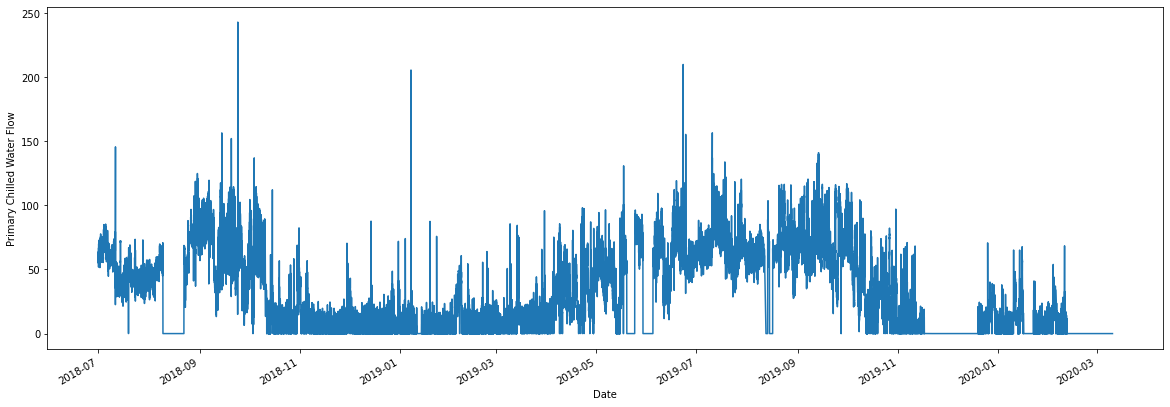

Finished 'dataframeplot' in 2.2740 secs


In [102]:
# Drop rows with NaN
flow = dp.dropNaNrows(flow)

# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='-')

### It has point outliers at this point. Let us first remove them


Retaining 80.72854534044201% of the data
Finished 'removeoutliers' in 8.1467 secs


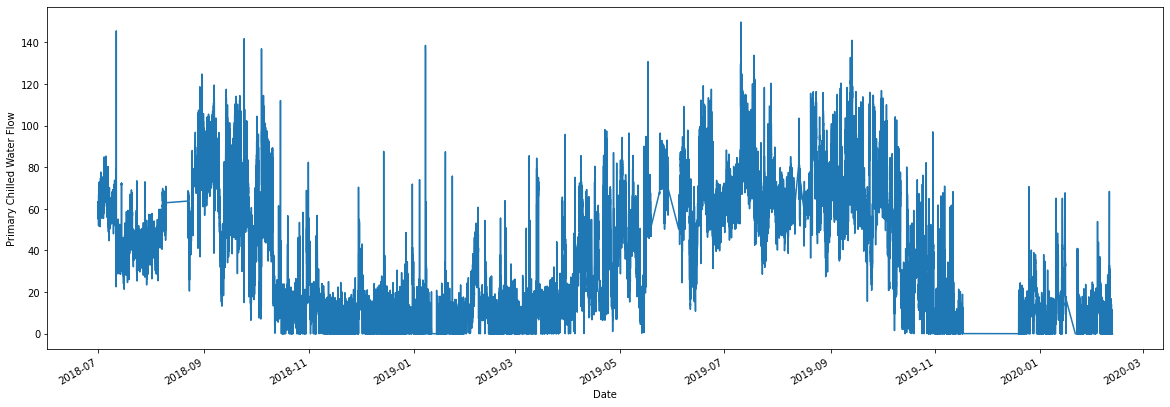

Finished 'dataframeplot' in 1.9069 secs


In [103]:
# remove outleirs based on bounds
name = ['Alumni_Hall_PCHW_Flow.value']
u_bound = [150]
l_bound = [0]
for i in range(len(name)):
    flow = dp.removeoutliers(flow,
                            columns=[name[i]],
                            upperbound=u_bound[i],
                            lowerbound=l_bound[i])
    
# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='-')

### Remove statistical outliers

In [104]:
# removing statistical outliers if any
# remove outliers based on z-thresh
col_list = ['Alumni_Hall_PCHW_Flow.value']
flow = dp.removeoutliers(flow, columns=col_list, z_thresh=3)

Retaining 99.96218143108266% of the data
Finished 'removeoutliers' in 0.0162 secs


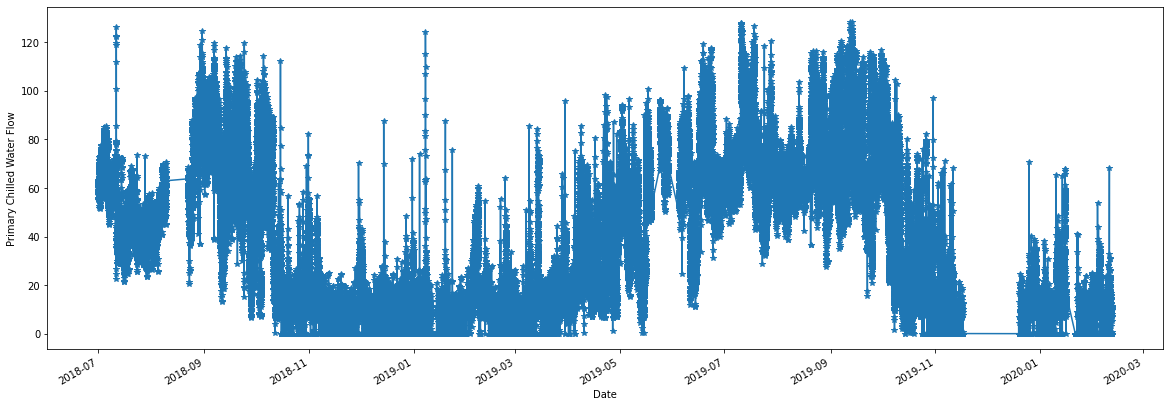

Finished 'dataframeplot' in 2.0462 secs


In [106]:
# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='*-')

### Resample data at 5 in intervals

In [107]:
flow_resampled = flow.copy()

In [108]:
flow_resampled = flow_resampled.resample('5min').asfreq()

### Interpolate the data

In [116]:
flow_interpolated = flow_resampled.interpolate(method='linear')

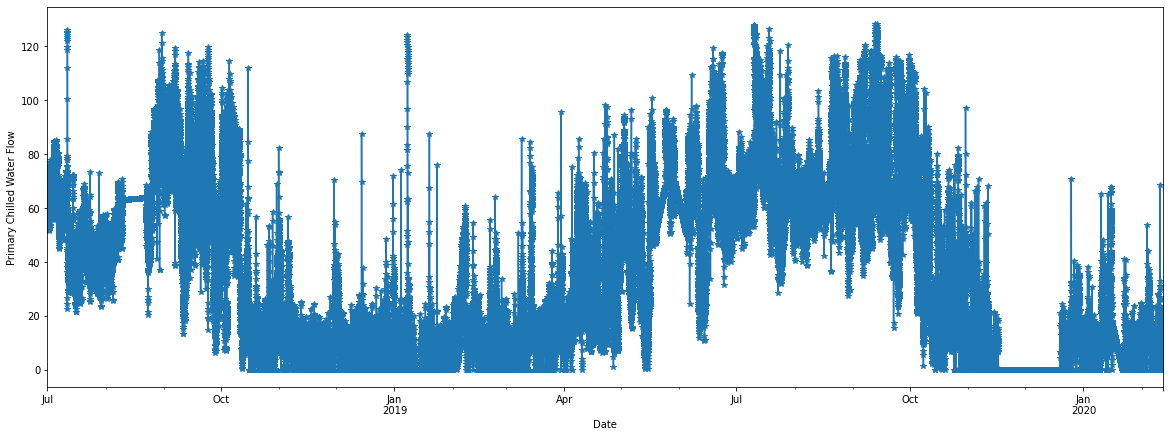

Finished 'dataframeplot' in 3.2560 secs


In [117]:
# Plot the df
dp.dataframeplot(flow_interpolated, ylabel='Primary Chilled Water Flow', xlabel='Date', style='*-')

### Save the dataframe

In [118]:
# Saving the processed data
flow_interpolated.to_pickle('../data/processed/interpolated/flow_interpolated.pkl')

# Get Hotwater Flow and supply temperature data

### Load the data

In [119]:
# load data path
hwdata = dp.readfile('../data/raw/energyvars/FileHotWaterSystem.csv',
                     timeformat='%Y-%m-%d %H:%M:%S+00:00',
                      dateheading='time')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
hw = hwdata.return_df(processmethods=processmethods)
hw = hw[[
    'HWR_T',
    'Hot_Water_Flow_AI_2',
    'HWS_T',
    'HWSP_STPT',
    'HX_Valve_1 ValvePosition',
]]

### Remove NaNs

In [121]:
# Drop Columns where >5% of values are NaN
hw = dp.dropNaNcols(hw, threshold=0.95)

# Drop rows with NaN
hw = dp.dropNaNrows(hw)

### Plot the dataframe

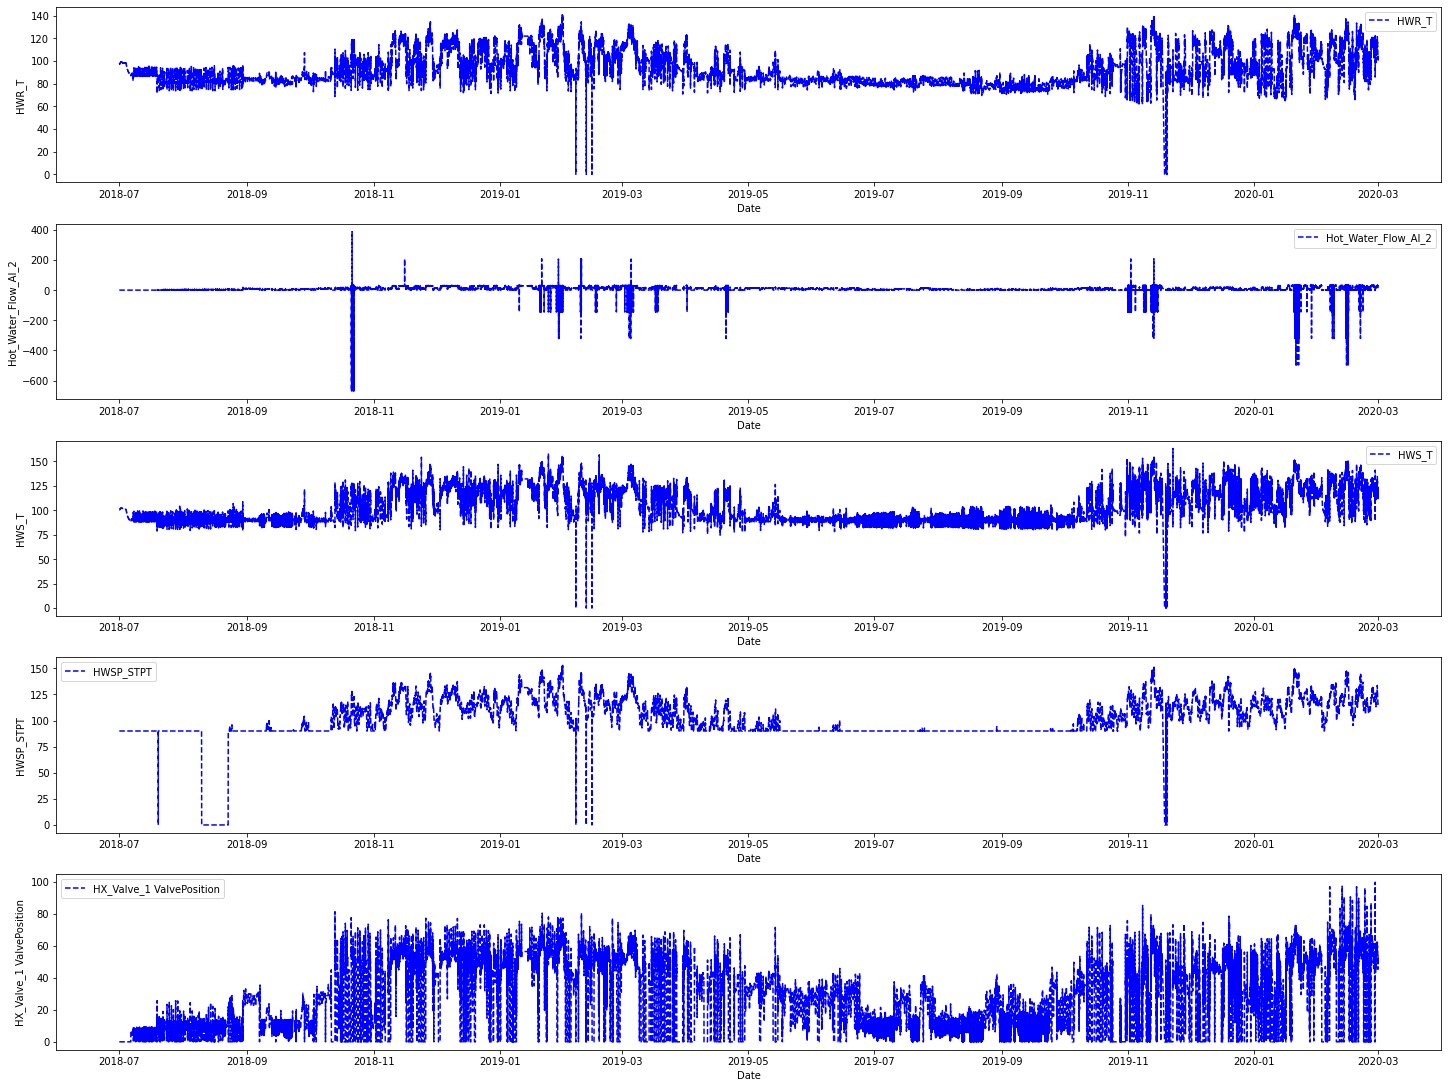

Finished 'dataframeplot' in 3.3813 secs


In [122]:
# Plot the df
dp.dataframeplot(hw, xlabel='Date', lazy=False, legend=True)

### Remove Statistical Outliers

In [123]:
# remove outliers based on z-thresh
col_list = [
    'HW_System.hwSupplyFlow', 'HW_System.hwSupplyTemp'
]
hw_cleaned = dp.removeoutliers(hw, columns=list(hw.columns), z_thresh=3)

Retaining 97.301753257198% of the data
Finished 'removeoutliers' in 0.0731 secs


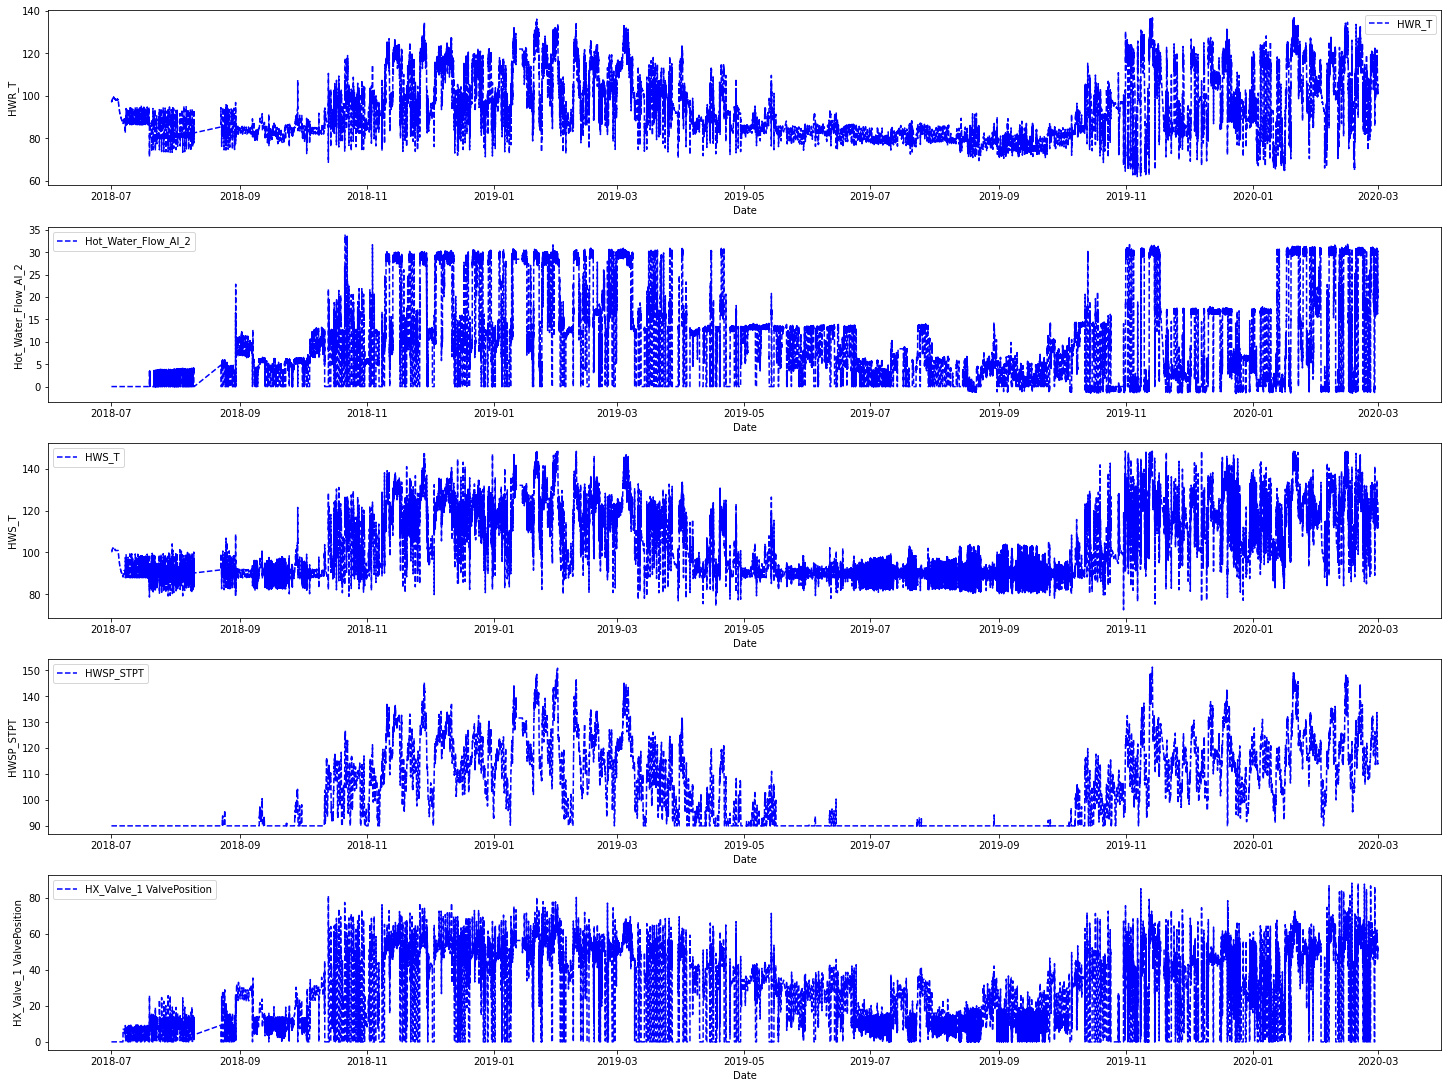

Finished 'dataframeplot' in 3.4426 secs


In [124]:
# Plot the df
dp.dataframeplot(hw_cleaned, xlabel='Date', lazy=False, legend=True)

### Rename columns for convenience

In [125]:
#rename columns
hw_cleaned.columns = ['hw_rt','hw_sf','hw_st','hw_s_stp','hx_vlv1']

### Resample

In [126]:
hw_resampled = hw_cleaned.copy()

hw_resampled = hw_resampled.resample('5min').asfreq()

### Interpolate

In [132]:
hw_interpolated = hw_resampled.interpolate(method='linear')

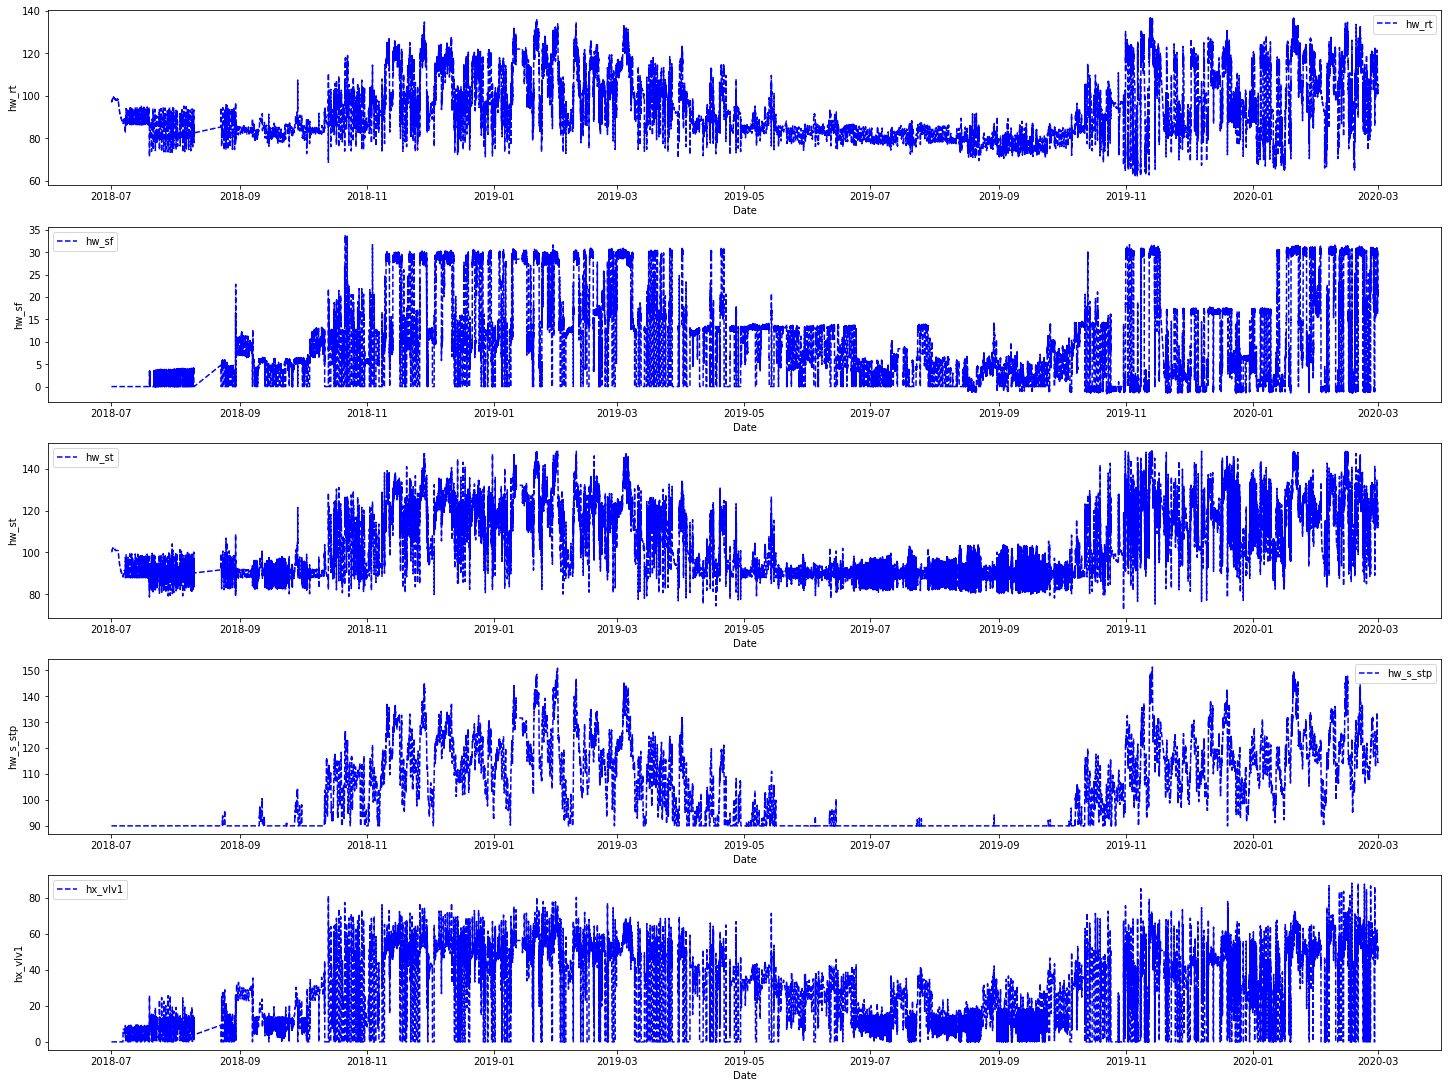

Finished 'dataframeplot' in 3.4400 secs


In [133]:
# Plot the df
dp.dataframeplot(hw_interpolated, xlabel='Date', lazy=False, legend=True)

### Save the data

In [134]:
# save the data in pickeld format
hw_interpolated.to_pickle('../data/processed/interpolated/hw_interpolated.pkl')

# Combining all 5 dataframes


In [136]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/interpolated/ahu_interpolated.pkl')
# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])



# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/interpolated/ghidf_interpolated.pkl')
# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])
ghi.columns = ['ghi']



# read the pickled file for vrf data
vrfdata = dp.readfile('../data/processed/interpolated/vrf_interpolated.pkl')
# return pickled df
vrf = vrfdata.return_df(processmethods=['file2df'])
# create row average
vrf['avg_stpt'] = vrf.mean(axis=1)
# drop cassette wise information
vrf.drop(columns=vrf.columns[:-1], inplace=True)



# read the pickled file for chilled water flow data
flowdata = dp.readfile('../data/processed/interpolated/flow_interpolated.pkl')
# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']



# read the pickled file for hot water data
hwdata = dp.readfile('../data/processed/interpolated/hw_interpolated.pkl')
# return pickled df
hw = hwdata.return_df(processmethods=['file2df'])

In [137]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, vrf, flow, hw])

In [138]:
df.head()

,AHU_1 outdoorAirTemp,AHU_1 supplyAirTemp,AHU_1 supplyAirTempSetpoint,WeatherDataProfile humidity,HW_BTU_METER currentKbtuDeltaReading,CHW_BTU_METER currentKbtuDeltaReading,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1
Time,,,,,,,,,,,,,,
2018-07-13 07:50:00,80.913567,79.320808,65.0,82.0,0.0,32.546185,562.0,69.52381,39.534317,89.589584,0.0,94.427994,90.0,0.276543
2018-07-13 07:55:00,80.913567,79.023285,65.0,82.0,0.0,29.293947,580.0,69.52381,39.809956,89.589584,0.0,94.125771,90.0,0.276543
2018-07-13 08:00:00,80.615402,79.023285,65.0,82.0,0.0,30.685425,597.0,69.52381,39.174774,89.589584,0.0,94.125771,90.0,0.276543
2018-07-13 08:05:00,80.303123,79.023285,65.0,82.0,0.0,30.074446,614.0,69.52381,35.745533,89.229790,0.0,93.816162,90.0,0.276543
2018-07-13 08:10:00,80.303123,79.023285,65.0,79.0,0.0,29.646845,625.0,69.52381,34.858036,89.229790,0.0,93.816162,90.0,0.276543


In [139]:
# renaming columns
df.columns = [
    'oat', 'sat', 'sat_stpt', 'orh', 'hwe', 'cwe', 'ghi', 'avg_stpt', 'flow',
    'hw_rt', 'hw_sf', 'hw_st', 'hw_s_stp', 'hx_vlv1'
]

# selecting relevant columns
df = df[[
    'oat', 'sat', 'orh', 'hwe', 'cwe', 'ghi', 'avg_stpt', 'flow', 'hw_sf',
    'hw_st', 'hw_rt', 'hx_vlv1'
]]

In [140]:
df.isna().sum()

oat         0
sat         0
orh         0
hwe         0
cwe         0
ghi         0
avg_stpt    0
flow        0
hw_sf       0
hw_st       0
hw_rt       0
hx_vlv1     0
dtype: int64

### Save the combined dataframe

In [143]:
df.to_pickle('../data/processed/interpolated/buildingdata_interpolated.pkl')

# Looking at the properties of the overall data

In [ ]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/interpolated/buildingdata_interpolated.pkl')
#dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df.plot(subplots=True)

In [ ]:
df = (df - df.min())/(df.max() - df.min())

### Mean and sigma plots

In [ ]:
def plot_props(groupyobj):
    
    mean = groupyobj.mean()
    std = groupyobj.std()
    mu_plus_3std = [mu+1*sigma for mu,sigma in zip(mean,std)]
    mu_minus_3std = [mu-1*sigma for mu,sigma in zip(mean,std)]
    dfmax = groupyobj.max()
    dfmin = groupyobj.min()
    idx = mean.index
    
    return idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin

In [ ]:
plt.figure(figsize=(13, 12))
plt.subplot(2, 2, 1)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['cwe'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate Chilled Water Energy')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='b', alpha=0.2, label='cwe mean +- 1 std dev bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['oat'].groupby(df.index.hour))
plt.plot(mean, 'r-.', label='Hourly aggregate oat')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='r', alpha=0.2, label='oat mean +- 1 std dev bounds')

plt.xlabel('Hour of the day')
#plt.ylim((-2,120))
plt.legend()
plt.tight_layout()


plt.subplot(2, 2, 2)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['cwe'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate Chilled Water Energy')
plt.fill_between(idx, dfmax, dfmin, color='b', alpha=0.2, label='cwe min max bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['oat'].groupby(df.index.hour))
plt.plot(mean, 'r-.', label='Hourly aggregate oat')
plt.fill_between(idx, dfmax, dfmin, color='r', alpha=0.2, label='oat min max bounds')

plt.xlabel('Hour of the day')
#plt.ylim((-2,120))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(13, 12))
plt.subplot(2, 2, 1)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['cwe'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate Chilled Water Energy')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='b', alpha=0.2, label='cwe mean +- 1 std dev bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['flow'].groupby(df.index.hour))
plt.plot(mean, 'g-.', label='Hourly aggregate Chilled Water Flow rate')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='g', alpha=0.2, label='hwe mean +- 1 std dev bounds')

plt.xlabel('Hour of the day')
plt.ylim((0,80))
plt.legend()
plt.tight_layout()


plt.subplot(2, 2, 2)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['cwe'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate Chilled Water Energy')
plt.fill_between(idx, dfmax, dfmin, color='b', alpha=0.2, label='cwe min max bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['flow'].groupby(df.index.hour))
plt.plot(mean, 'g-.', label='Hourly aggregate Chilled Water Flow rate')
plt.fill_between(idx, dfmax, dfmin, color='g', alpha=0.2, label='flow min max bounds')


plt.xlabel('Hour of the day')
plt.ylim((0,80))
plt.legend()
plt.tight_layout()
plt.show() 

In [ ]:
plt.figure(figsize=(13, 12))
plt.subplot(2, 2, 1)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hw_sf'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate hw_sf')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='b', alpha=0.2, label='hw_sf mean +- 1 std dev bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hwe'].groupby(df.index.hour))
plt.plot(mean, 'r-.', label='Hourly aggregate Hot Water Energy')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='r', alpha=0.2, label='hwe mean +- 1 std dev bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hx_vlv1'].groupby(df.index.hour))
plt.plot(mean, 'g-.', label='Hourly aggregate hx_vlv1')
plt.fill_between(idx, mu_plus_3std, mu_minus_3std, color='g', alpha=0.2, label='hx_vlv1 mean +- 1 std dev bounds')

plt.xlabel('Hour of the day')
plt.ylim((-2,100))
plt.legend()
plt.tight_layout()


plt.subplot(2, 2, 2)
# looking at the hourly behavior of energy data
idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hw_sf'].groupby(df.index.hour))
plt.plot(mean, 'b-.', label='Hourly aggregate hw_sf')
plt.fill_between(idx, dfmax, dfmin, color='b', alpha=0.2, label='hw_sf min max bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hwe'].groupby(df.index.hour))
plt.plot(mean, 'r-.', label='Hourly aggregate Hot Water Energy')
plt.fill_between(idx, dfmax, dfmin, color='r', alpha=0.2, label='hwe min max bounds')

idx, mean, mu_plus_3std, mu_minus_3std, dfmax, dfmin = plot_props(df['hx_vlv1'].groupby(df.index.hour))
plt.plot(mean, 'g-.', label='Hourly aggregate hx_vlv1')
plt.fill_between(idx, dfmax, dfmin, color='g', alpha=0.2, label='hx_vlv1 min max bounds')

plt.xlabel('Hour of the day')
plt.ylim((-2,150))
plt.legend(loc='upper right')
plt.tight_layout()
plt.show() 

### Scatter Plots

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))

plt.subplot(1,1,1)

xlabel = 'sat'
ylabel = 'hwe'

x,y = df[xlabel], df[ylabel]
plt.scatter(x, y, c=y, cmap='viridis')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

In [ ]:
df_hourly = df.resample('1440min').asfreq()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))



xlabel = 'sat'#'hw_sf'
ylabel = 'avg_stpt'#'hx_vlv1'
zlabel = 'cwe'
x, y, z  = df_hourly[xlabel].to_numpy(), df_hourly[ylabel].to_numpy(), df_hourly[zlabel].to_numpy()


ax = plt.subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='viridis')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

plt.show()

# Reshaping data for sequential learning

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/interpolated/buildingdata_interpolated.pkl')
#dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])